#### Object Recognition W/ YOLOv3
#### Anura Ranasinghe (sar2jf)
#### DS6050: Deep Learning

<br>

Code for this notebook has been derived from the following sites: 

https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

https://medium.com/@anirudh.s.chakravarthy/training-yolov3-on-your-custom-dataset-19a1abbdaf09

https://medium.com/@desjoerdhaan/kitti-3d-object-detection-data-set-ef8ee6409574

Dataset and annotations is from the KITTI Vision Benchmark Suite, found at http://www.cvlibs.net/datasets/kitti/index.php

<br>

In [2]:
import struct
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
from matplotlib import image
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from PIL import Image

from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array

<br>

#### Set File Paths

In [3]:
# Paths To Images / Labels of Original KITTI Dataset

img_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Data/kitti/training/image_2/'
label_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Data/kitti/training/label_2/'

# Paths To Converted Images (.JPG) and Formatted Labels 

new_img_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Code/darknet/data/Images/'
new_label_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Code/darknet/data/labels/'


In [4]:
# Number of files in original image directory

len([filename for filename in os.listdir(img_dir)])


7480

In [5]:
# Number of files in original image directory

len([filename for filename in os.listdir(label_dir)])


7480

<br>

#### Initial Cleaning of Darknet Directories

##### Delete ".ipynb_checkpoints" files from original KITTI images and labels dataset
Not sure exactly what this is; downloaded with KITTI dataset

In [39]:
# Delete from image directory

checkpoint_path = img_dir + '.ipynb_checkpoints/'

if os.path.exists(checkpoint_path):
    os.rmdir(checkpoint_path)
else:
    print('File Does Not Exist')


File Does Not Exist


In [42]:
# Delete from label directory

checkpoint_path = label_dir + '.ipynb_checkpoints/'

# Remove files in this checkpoint directory first

#for filename in os.listdir(checkpoint_path):
    
    #temp_path = checkpoint_path + filename
    #os.remove(temp_path)
    
if os.path.exists(checkpoint_path):
    os.rmdir(checkpoint_path)
else:
    print('File Does Not Exist')


File Does Not Exist


In [79]:
# Delete from new label directory

checkpoint_path = new_label_dir + '.ipynb_checkpoints/'

# Remove files in this checkpoint directory first

#for filename in os.listdir(checkpoint_path):
    
    #temp_path = checkpoint_path + filename
    #os.remove(temp_path)

if os.path.exists(checkpoint_path):
    os.rmdir(checkpoint_path)
else:
    print('File Does Not Exist')


File Does Not Exist


##### Empty Darknet label directory
Miscellaneous .PNG files found from original git pull

In [80]:

for filename in os.listdir(new_label_dir):
    
    temp_path = new_label_dir + filename
    os.remove(temp_path)

<br>

#### View Sample Data

In [6]:
# Get paths for sample image

img_no = '000027'
img_path = img_dir + img_no + '.png'

sample_png = load_img(img_path)

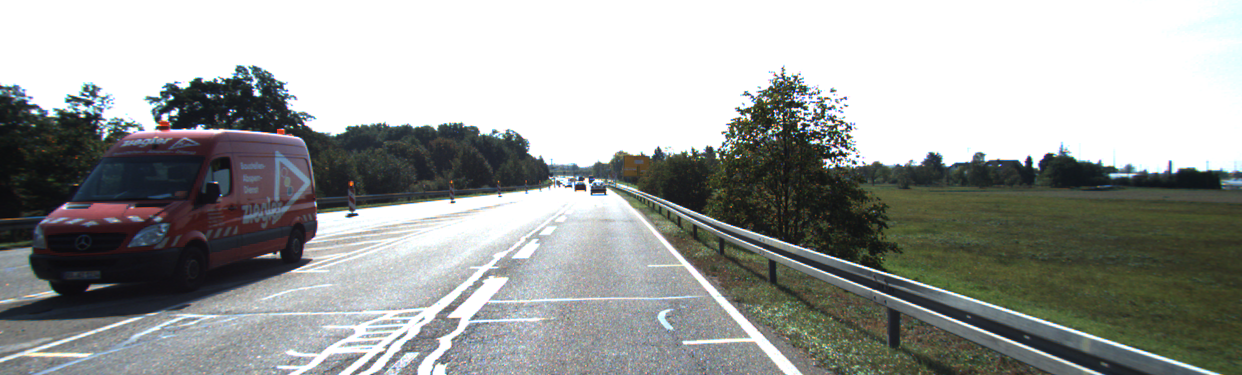

In [7]:
sample_png

In [8]:
sample_png.size

(1242, 375)

In [63]:
# Get paths for sample label

label_path = label_dir + img_no + '.txt'
sample_label = pd.read_csv(label_path, sep=" ", names=['label', 'truncated', 'occluded', 'alpha', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 'loc_x', 'loc_y', 'loc_z', 'rotation_y'])

sample_label


,label,truncated,occluded,alpha,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dim_height,dim_width,dim_length,loc_x,loc_y,loc_z,rotation_y
0,Van,0.0,3,2.06,16.35,117.65,314.78,314.78,2.72,1.9,5.78,-7.39,1.99,12.90,1.55
1,Car,0.0,0,-1.58,590.88,181.60,607.07,194.48,1.26,1.6,3.56,-1.15,2.16,73.46,-1.59
2,DontCare,-1.0,-1,-10.00,563.21,177.96,583.73,194.34,-1.00,-1.0,-1.00,-1000.00,-1000.00,-1000.00,-10.00


<br>

#### Convert Images to .JPG and Save to Darknet Folder

In [15]:
for filename in os.listdir(img_dir):
    
    input_path = img_dir + filename
    
    try:
        png_img = cv2.imread(input_path)

        output_path = new_img_dir + filename[:-4] + '.jpg'
        cv2.imwrite(output_path, png_img)
    
    except:
        pass


In [59]:
# View Newly Created .JPG Images

img_no = '000027'
new_img_path = new_img_dir + img_no + '.jpg'

sample_jpg = load_img(img_path)

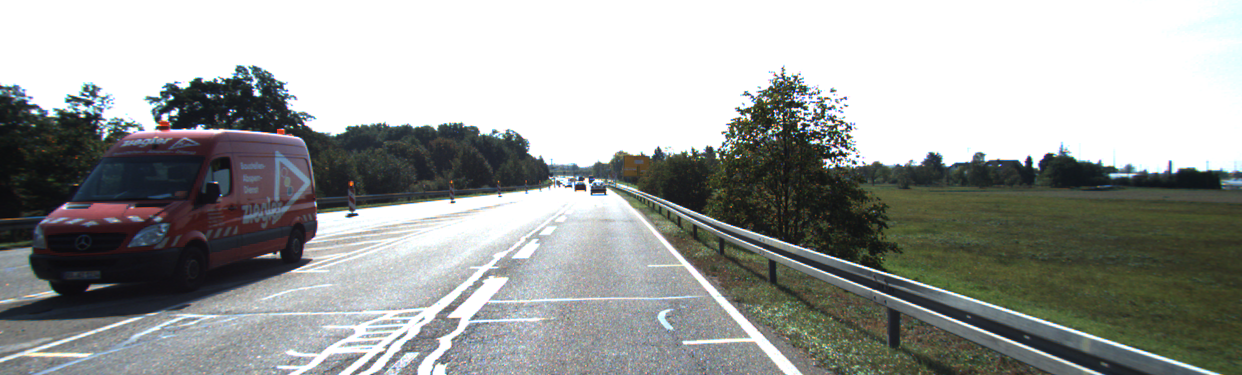

In [61]:
sample_jpg

In [62]:
sample_jpg.size

(1242, 375)

<br>

#### Format .txt Label Files For YOLO Training

See link below for details regarding training: 

https://medium.com/@anirudh.s.chakravarthy/training-yolov3-on-your-custom-dataset-19a1abbdaf09

We note that each image file requires a corresponding label file with the same name. The KITTI dataset labels have the be formatted to match the following:

object-class, x_center, y_center, width, height

##### Need to create dictionary of object label names with indices

In [66]:
# Find distinct list of objects in KITTI dataset

obj_list = []

for filename in os.listdir(label_dir):

    file_path = label_dir + filename
    
    try: 
        file = open(file_path)
        
        labels = file.readlines()
    
        for line in labels:
        
            new_line = line.split(' ')
            obj = new_line[0]
        
            obj_list.append(obj)
                
        file.close()
        
    except:
        pass
    
obj_list = list(set(obj_list))
obj_list

['Tram',
 'Truck',
 'Van',
 'Car',
 'Misc',
 'DontCare',
 'Person_sitting',
 'Cyclist',
 'Pedestrian']

In [67]:
obj_dict = {'Car': 0, 
            'Cyclist': 1, 
            'Misc': 2, 
            'Pedestrian': 3, 
            'Person_sitting': 4, 
            'Tram': 5, 
            'Truck': 6, 
            'Van': 7,             
            'DontCare': 8, 
}

obj_dict

{'Car': 0,
 'Cyclist': 1,
 'DontCare': 2,
 'Misc': 3,
 'Pedestrian': 4,
 'Person_sitting': 5,
 'Tram': 6,
 'Truck': 7,
 'Van': 8}

##### Map labels .txt files to new label file

In [81]:
# Loop over label files and create newly formatted label files


for file_name in os.listdir(label_dir):
    
    try:

        # Input file info

        img_no = file_name[:-4]
        img_path = img_dir + img_no + '.png'
        label_path = label_dir + img_no + '.txt'

        # Get original image size for downstream normalization

        img = Image.open(img_path)
        img_w, img_h = img.size

        # Open label file

        file = open(label_path)
        old_labels = file.readlines()
        new_lines = []

        for line in old_labels:

            # Initial Formatting

            line = line.replace('\n', '')   
            line = line.split(' ')

            if line[0] == 'DontCare':
                continue

            line[1:] = [float(x) for x in line[1:]]

            # New Variables

            obj_idx = obj_dict[line[0]]

            xmid = ((line[4] + line[6]) / 2) / img_w
            ymid = ((line[5] + line[7]) / 2) / img_h

            width = (line[6] - line[4]) / img_w
            height = (line[7] - line[5]) / img_h

            new_line = [obj_idx, xmid, ymid, width, height]
            new_line = [round(x, 3) for x in new_line]
            new_line = [str(x) for x in new_line]
            new_line = ' '.join(new_line)

            new_lines.append(new_line)

        # Create new file and write new_lines

        new_label_path = new_label_dir + img_no + '.txt'

        try:
            with open(new_label_path, 'x') as f:
                for line in new_lines:
                    f.write(line + '\n')

        except:
            with open(new_label_path, 'w') as f:
                for line in new_lines:
                    f.write(line + '\n')
                    
    except:
        pass


In [82]:
# Number of files in new label directory

len([filename for filename in os.listdir(new_label_dir)])


7480

##### Test x, y center coordinates for a given image by plotting

In [83]:
# Path information

img_no1 = '000063'

img_path = img_dir + img_no1 + '.png'
new_label_path = new_label_dir + img_no1 + '.txt'

img = Image.open(img_path)
img_w, img_h = img.size

imgNo1_labels = pd.read_csv(new_label_path, sep=" ", names=['label', 'xcenter', 'ycenter', 'width', 'height'])


In [84]:
imgNo1_labels

,label,xcenter,ycenter,width,height
0,0,0.745,0.586,0.081,0.183
1,0,0.323,0.612,0.183,0.301
2,4,0.349,0.625,0.035,0.331
3,8,0.698,0.513,0.039,0.123


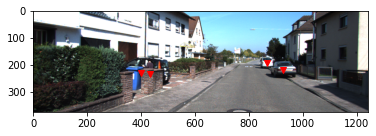

In [85]:
data = image.imread(img_path)

for i in range(imgNo1_labels.shape[0]):
    
    plt.plot(imgNo1_labels['xcenter'][i] * img_w, 
             imgNo1_labels['ycenter'][i] * img_h, 
             marker='v', color="red")
    
plt.imshow(data)
plt.show()

<br>

#### Create .txt. Files That Lists Paths To Each Img / Label

In [119]:
# Image Path Listing

list_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Data/kitti/training/'
trainImg_paths = list_dir + 'trainImg_paths.txt'
path_counter = 0

with open(trainImg_paths, 'x') as f:
    
    
    for filename in os.listdir(img_dir):
        
        path = img_dir + filename + '\n'
        f.write(path)
        
        path_counter += 1
    
    print('Paths created: ' + str(path_counter))


Paths created: 7481


In [120]:
# Image Path Listing

list_dir = '/sfs/qumulo/qhome/sar2jf/Documents/ds6050_finalproj/Data/kitti/training/'
trainLabel_paths = list_dir + 'trainLabel_paths.txt'
path_counter = 0

with open(trainLabel_paths, 'x') as f:
    
    
    for filename in os.listdir(new_label_dir):
        
        path = new_label_dir + filename + '\n'
        f.write(path)
        
        path_counter += 1
    
    print('Paths created: ' + str(path_counter))


Paths created: 7481
